# Creating Panoramas and HDR images
Panoramas simply add stitching to aligned/warped images.

HDR (High Dynamic Range) is a composite of multiple images taken at different exposures, but in order to put them together, we also first need to align them.

# Steps for Creating Panoramas

1. Find keypoints in all images
2. Find pairwise correspondences
2. Estimate pairwise Homographies
3. Refine Homographies
3. Stitch with Blending

# Steps for Creating Panoramas using OpenCV

1. Use the **sticher** class
2. There is no step 2. It's that simple :)


In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import math

In [2]:
# Read Images

imagefiles = glob.glob("boat/*")
imagefiles.sort()

images = []
for filename in imagefiles:
  img = cv2.imread(filename)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images.append(img)

num_images = len(images)


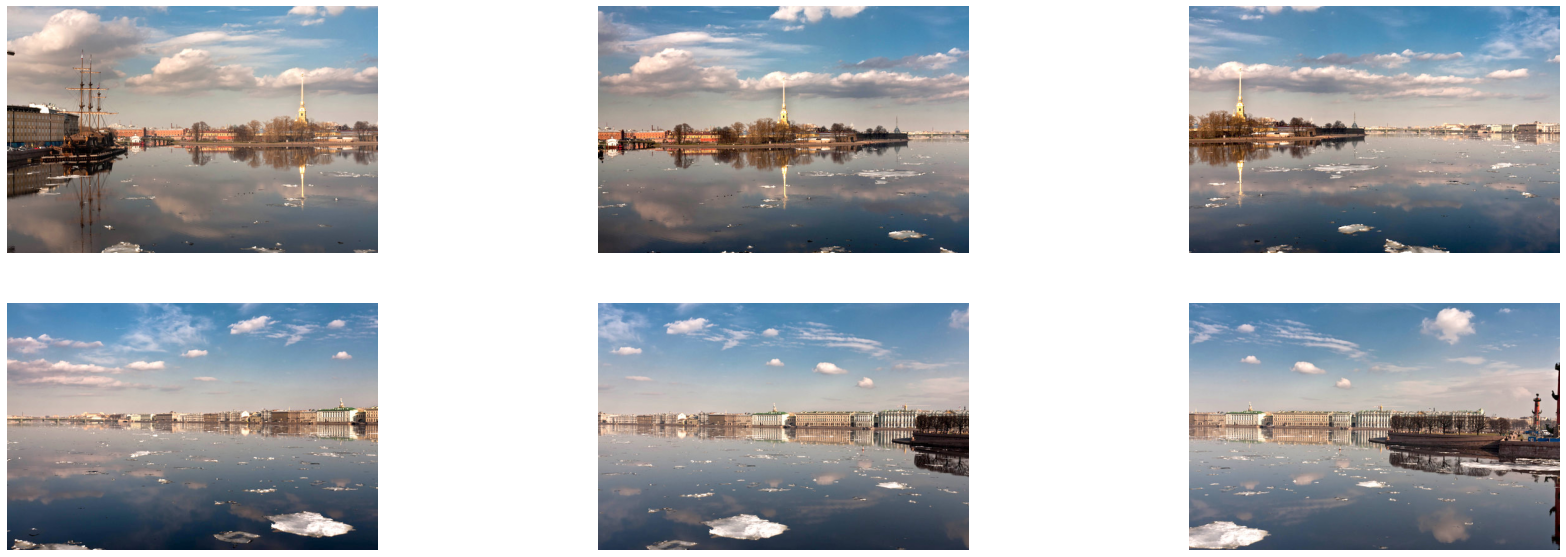

In [3]:
# Display Images
plt.figure(figsize=[30,10]) 
num_cols = 3
num_rows = math.ceil(num_images / num_cols)
for i in range(0, num_images):
  plt.subplot(num_rows, num_cols, i+1) 
  plt.axis('off')
  plt.imshow(images[i])


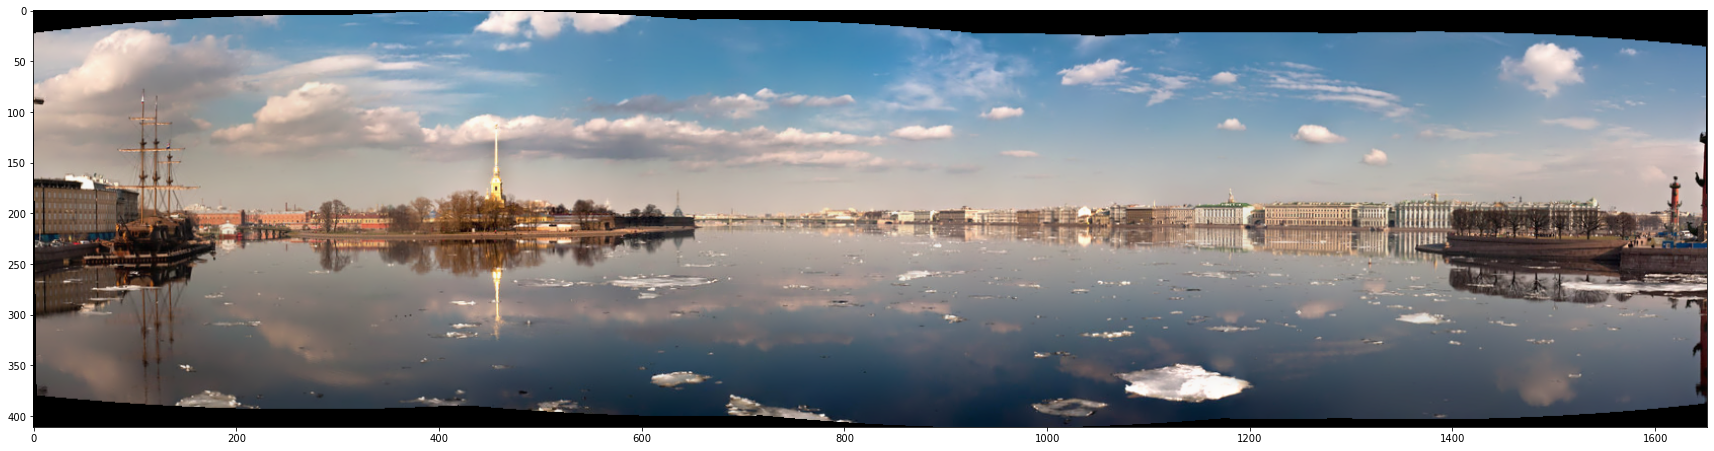

In [4]:
# Stitch Images
stitcher = cv2.Stitcher_create()
status, result = stitcher.stitch(images)
if status == 0:
  plt.figure(figsize=[30,10]) 
  plt.imshow(result)

# High Dynamic Range (HDR) Imaging

Multiple exposures combined into one image, with better color range.

When taking photos, your result might have shadows (dark areas) that are well-exposed with plenty of color and detail. But the highlights (bright areas) are over-exposed (pure white with no color or detail).
!["HDR Image Example"](high-dynamic-range-hdr-x1.jpeg)

Or the highlights will be well-exposed with plenty of color and detail. But the shadows appear under-exposed (very dark with no color or detail).
!["HDR Image Example"](high-dynamic-range-hdr-x2.jpeg)

So, how can you get a more balanced photo, like so?
!["HDR Image Example"](high-dynamic-range-hdr-x3.jpeg)

On most modern phones, you can solve these problems by turning on the HDR option. With that, you can capture well-lit photos with a balanced exposure throughout, whether it's for images of people...
!["HDR Image Example"](high-dynamic-range-hdr-2.jpeg)

...or places.
!["HDR Image Example"](high-dynamic-range-hdr-3.png)

It achieves this by taking multiple captures of the scene in quick succession (so that the position of the camera, lighting conditions etc haven't changed between captures), and then combines them into one single image.

As such, HDR requires images to be aligned, and that there's no motion in-between them. Otherwise, you end up with ghosting effects due to motion.
!["Moving HDR Image Example"](high-dynamic-range-hdr-moving.jpeg)


Why isn't it just ON by default? Coz photography is an art, and there are times when you want to capture a silhouette, like so
!["Non-HDR Image Example"](high-dynamic-range-hdr-no.jpeg)

HDR will not let you do so.

# Basic Idea

1. The **dynamic range** of images is limited to 8-bits (0 - 255) per channel
2. Very bright pixels saturate to 255
3. Very dark pixels clip to 0

# Step 1: Capture Multiple Exposures

!["HDR Image Sequence"](hdr-image-sequence.jpg)


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#convenience function to store images and their exposure times together
def readImagesAndTimes():
  # List of file names  
  filenames = ["img_0.033.jpg", "img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]
  
  # List of exposure times  
  times = np.array([ 1/30.0, 0.25, 2.5, 15.0 ], dtype=np.float32)
  
  # Read images 
  images = []
  for filename in filenames:
    im = cv2.imread(filename)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    images.append(im)
  
  return images, times


# Step 2: Align Images

![Aligned vs. Unaligned](aligned-unaligned-hdr-comparison.jpg)

Since images are at different exposures, standard alignment methods may not work.

We instead use a function in OpenCV called Align Median Threshold Bitmap. 

You can read more about how it works [here](http://www.anyhere.com/gward/papers/jgtpap2.pdf)

In [6]:
# Read images and exposure times
images, times = readImagesAndTimes()

# Align Images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)

The alignment isn't as huge in the images we use, so here's an extreme example to show how the result from an AlignMTB process would look like.

If we have images like these
!["MTB Unaligned"](mtb_unaligned.png)

The output would be an aligned set, like so
!["MTB Aligned"](mtb_aligned.png)

# Step 3: Estimate Camera Response Function
A camera measures the light intensity hitting the imaging sensor and outputs an image with pixel values that in some way correspond to that light intensity. This correspondence is modeled by the camera response function (CRF).

!["CRF"](crf.gif)

Most cameras we use are not linear, meaning, that if the radiance in a scene is doubled, the pixel intensities recorded by the camera will not necessarily double. 
This presents a problem when we want to merge images taken at different exposures.

If the RF was linear, then the intensities of the input images could be simply scaled by their exposure times (which would put them on the same radiance scale), and then we can simply compute an average intensity at every pixel location across those images to synthesize and HRD image.

However, since it's not linear, we need to estimate it so we can first linearize the images before combining them.

Since the RF is considered proprietary information (by manufacturer), we need to use the images to estimate it. This is a rather involved optimisation problem, but luckily, there exist two algorithms in OpenCV that can do this for us; one by Debevec & another by Robertson. We will use the former.


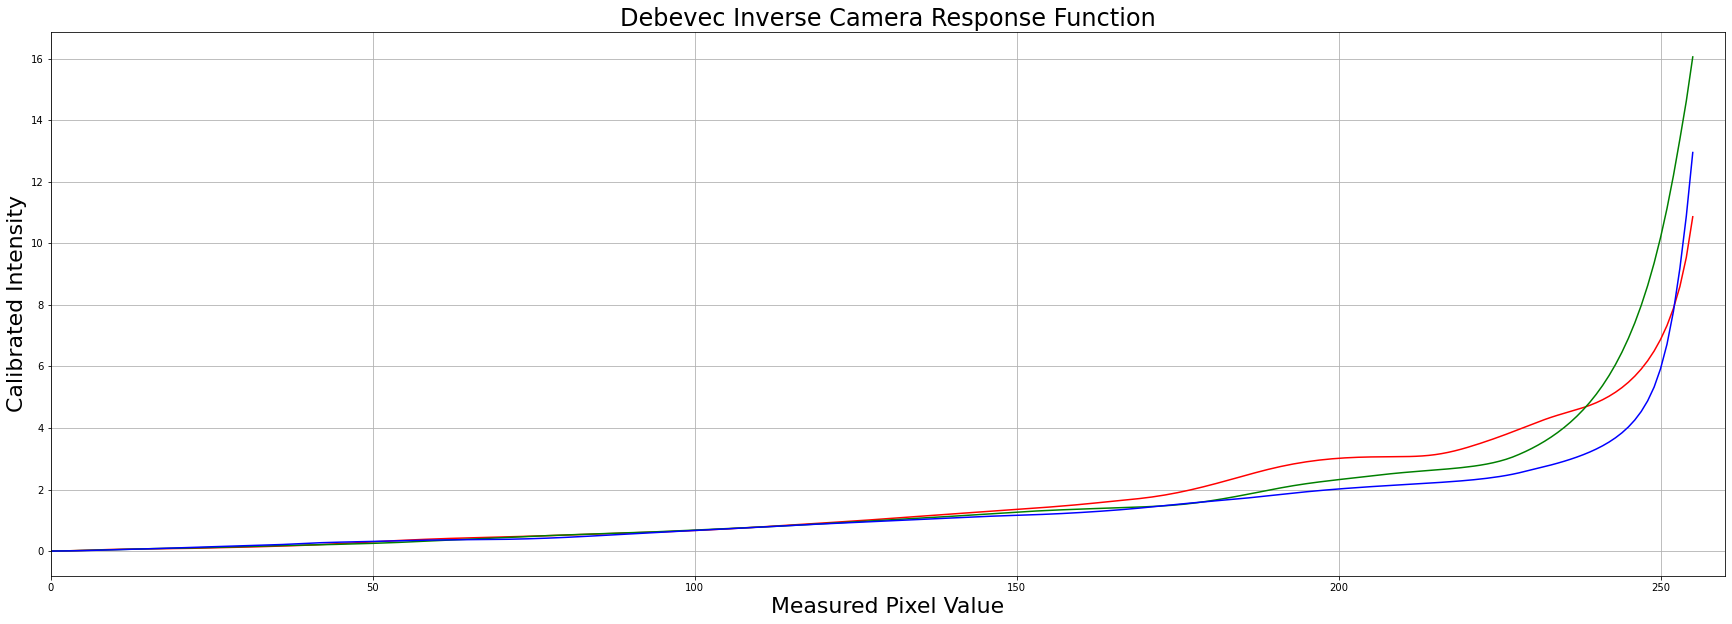

In [7]:
# Find Camera Response Function (CRF)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

# Plot CRF
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30,10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0,260])
plt.grid()
plt.plot(x, y[:,0],'r'  , x, y[:,1],'g', x, y[:,2],'b');

Note how the RF is fairly linear in the lower intensity values, starts to become non-linear in the middle, and finally, at the higher end of the spectrum, we start to see some clipping at 255 as the intensities in the actual scene exceed the recording limit of the camera.

Also note that the 3 channels are calibrated separately since the sensitivities are slightly different.

# Step 4: Merge Exposure into an HDR Image
Now we can use the above function to linearize the input images by mapping the measured pixel intensity in those images to the calibrated intensity, so that the images can then be merged appropriately.

We use the MergeDebevec functionality for this.

PS: The merging process ignores pixel values close to 0 and 255, since pixel values close to those extremes contain no useful information. Sometimes you'll find an extra step to filter those out as a result.

In [8]:
# Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

# Step 5: Tonemapping 
Tone mapping is a technique used in image processing and computer graphics to map one set of colors to another to approximate the appearance of high-dynamic-range images in a medium that has a more limited dynamic range. ~ Wikipedia

The intensity values from the last step are no longer in the 0-255 range. Black is still 0, but HDR images can record intensities up to infinite brightness. Because they have a fixed range, they have to be stored in 32bit floating point numbers, but since our displays require 8-bit images, we need 1 last step to bring the intensities back down to 0-255 range.

Basically, our screens can't display HDR, so we convert the pixel values back to SDR so we can see the image correctly.

Many Tonemapping algorithms are available in OpenCV. 
There's no "correct way" to perform tonemapping. Sometimes the goal is to achieve something aesthetically pleasing that isn't necessarily realistic. Most of OpenCV's algorithms for this tend to be fairly realistic, but each is different and has various parameters you can play around with.

Common parameters of the different tone mapping algorithms are listed below:

* **gamma** : This parameter compresses the dynamic range by applying a gamma correction. When gamma is equal to 1, no correction is applied. A gamma of less than 1 darkens the image, while a gamma greater than 1 brightens the image.
* **saturation** : This parameter is used to increase or decrease the amount of saturation. When saturation is high, the colors are richer and more intense. Saturation value closer to zero, makes the colors fade away to grayscale.
* **contrast** : Controls the contrast ( i.e. log (maxPixelValue/minPixelValue) ) of the output image.

saved ldr-Drago.jpg


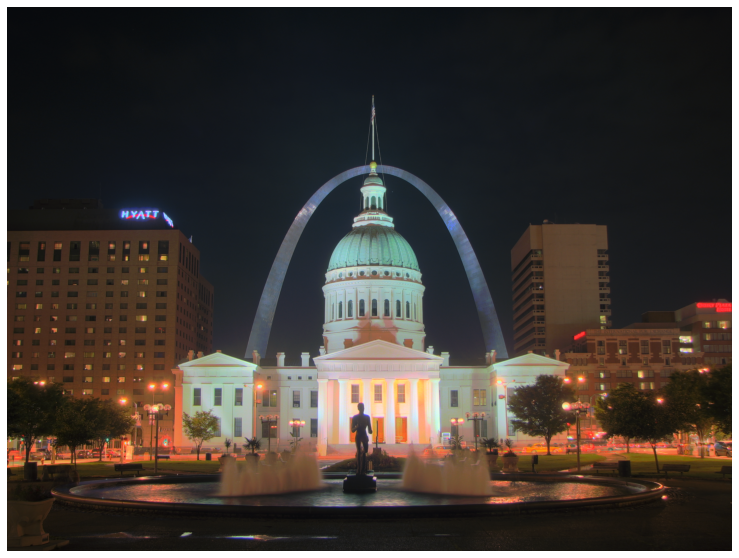

In [9]:
# Tonemap using Drago's method to obtain 24-bit (8-bit per channel) color image
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago
plt.figure(figsize=(20,10)); plt.imshow(np.clip(ldrDrago,0,1)); plt.axis('off');
cv2.imwrite("ldr-Drago.jpg", ldrDrago * 255)
print("saved ldr-Drago.jpg")


Tonemaping using Reinhard's method ... 
saved ldr-Reinhard.jpg


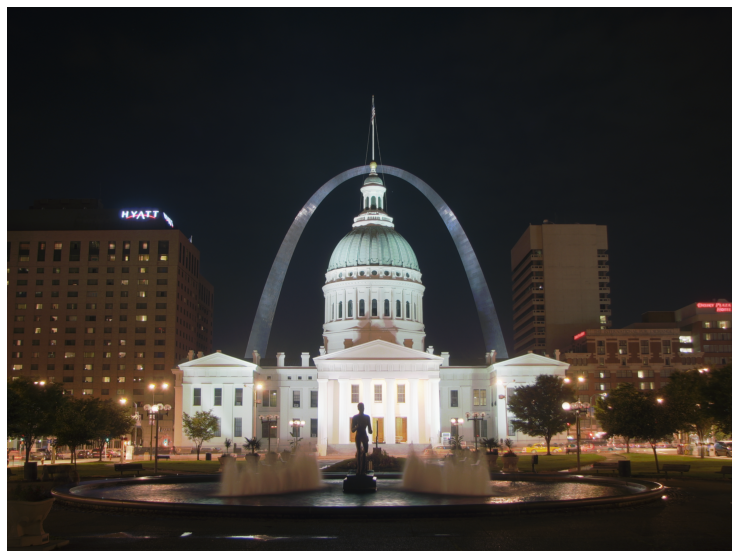

In [10]:
# Tonemap using Reinhard's method to obtain 24-bit color image
print("Tonemaping using Reinhard's method ... ")
tonemapReinhard = cv2.createTonemapReinhard(1.5, 0,0,0)
ldrReinhard = tonemapReinhard.process(hdrDebevec)
plt.figure(figsize=(20,10)); plt.imshow(np.clip(ldrReinhard,0,1)); plt.axis('off');
cv2.imwrite("ldr-Reinhard.jpg", ldrReinhard * 255)
print("saved ldr-Reinhard.jpg")

Tonemaping using Mantiuk's method ... 
saved ldr-Mantiuk.jpg


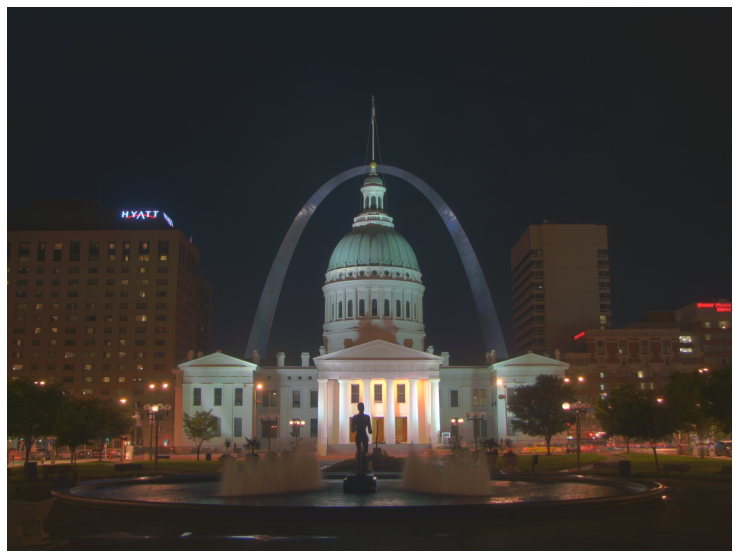

In [11]:
# Tonemap using Mantiuk's method to obtain 24-bit color image
print("Tonemaping using Mantiuk's method ... ")
tonemapMantiuk = cv2.createTonemapMantiuk(2.2,0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(hdrDebevec)
ldrMantiuk = 3 * ldrMantiuk
plt.figure(figsize=(20,10)); plt.imshow(np.clip(ldrMantiuk,0,1)); plt.axis('off');
cv2.imwrite("ldr-Mantiuk.jpg", ldrMantiuk * 255)
print("saved ldr-Mantiuk.jpg")

The Durand algorithm is based on the decomposition of the image into a base layer and a detail layer. The base layer is obtained using an edge-preserving filter called the bilateral filter. sigma_space and sigma_color are additional parameters of the bilateral filter that control the amount of smoothing in the spatial and color domains respectively.

    createTonemapDurand
    (
      float 	gamma = 1.5f,
      float 	contrast = 4.0f,
      float 	saturation = 1.0f,
      float 	sigma_space = 1.0f,
      float 	sigma_color = 1.0f
    )

In [13]:
# Tonemap using Durand's method obtain 24-bit color image
tonemapDurand = cv2.xphoto.createTonemapDurand(1.5,4,1.0,1,1)
ldrDurand = tonemapDurand.process(hdrDebevec)
ldrDurand = 3 * ldrDurand
plt.figure(figsize=(20,10)); plt.imshow(np.clip(ldrDurand,0,1)); plt.axis('off');
cv2.imwrite("ldr-Durand.jpg", ldrDurand * 255)
print("saved ldr-Durand.jpg")

error: OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv_contrib/modules/xphoto/src/tonemap.cpp:125: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'createTonemapDurand'
